In [1]:
import numpy as np
from matplotlib import pyplot as plt
from Bio import Phylo
from Bio.Seq import Seq
import random
import string
from Bio.Phylo.BaseTree import Tree, Clade
from itertools import product
from keras.utils import to_categorical

# Root: MRCA (Most Recent Common Ancestor) of all known given present known taxa ("terminal" taxa of "leaves")
# Parent: "parent" node, given an edge
# Child/children: "children" nodes or "child" node, given an edge 
# Ancestor: any node along the chain of parents, starting from a node 
# Descendant: any node belonging to a clade, starting from a node
# Terminal: "leaf" nodes in the tree

seed = 3
random.seed(seed)
np.random.seed(seed)

# Define bases
purines = ["A", "G"]
pyrimidines = ["C", "T"]
bases = purines + pyrimidines
n_bases = len(bases)

def index_to_sequence(idx):
    seq = "".join([bases[i] for i in idx])
    return seq

def sequence_to_index(seq):
    idx = []
    for base in seq:
        idx.append(np.where(np.array(bases) == base)[0][0])
    idx = np.array(idx)
    return idx

def generate_sequence(seq_len, prob=None, return_idx=False):
    if prob is None:
        idx = np.random.randint(0, n_bases, size=seq_len)
    else:
        idx = np.random.choice(len(prob), size=seq_len, p=prob)
    seq = index_to_sequence(idx)

    if return_idx: 
        return seq, idx
    else: 
        return seq

def Markov_matrix(alpha, edge_len):
    a = 3 / 4 * (1 - np.exp(-4 / 3 * alpha * edge_len))
    M = (a / 3 *  np.ones((n_bases, n_bases)) + (1 - 4 / 3 * a) * np.diag(np.ones(n_bases)))
    return M

def Markov_process(p_init, transition_matrix):
    p_final = p_init @ transition_matrix
    return p_final

def generate_child_from_parent(parent, alpha, edge_len, return_idx=False): # can accept either sequence or indices
    seq_len = len(parent)

    if type(parent) == str:
        parent_idx = sequence_to_index(parent)
    else:
        parent_idx = parent
    parent_prob = to_categorical(parent_idx, num_classes=n_bases) # one-hot encoding
    M = Markov_matrix(alpha, edge_len)
    child_prob = Markov_process(parent_prob, M)
    child_seq = "".join([generate_sequence(1, prob=child_prob[i])[0] for i in range(seq_len)])
    
    if return_idx:
        child_idx = sequence_to_index(child_seq)
        return child_seq, child_idx
    else:
        return child_seq

def count_mutations(parent_seq, child_seq):
    n_mutations = sum(x != y for x, y in zip(parent_seq, child_seq))
    return n_mutations

def generate_random_taxa_names(n_taxa, from_alphabet=False):
    if from_alphabet:
        alphabet = string.ascii_uppercase
        n_alphabet = len(alphabet)
        iter = int(np.ceil(np.emath.logn(n_alphabet, n_taxa)))
        keywords = [''.join(i) for i in product(alphabet, repeat=iter)]
        random_taxa_names = random.sample(keywords, k=n_taxa)
    else:
        random_taxa_names = [f"S{i}" for i in range(n_taxa)]
    return random_taxa_names

def get_parent_node(node, parents):
        return parents.get(node)

c:\Users\leonm\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: c:\Users\leonm\AppData\Local\Programs\Python\Python310\lib\site-packages
  warnings.warn(


In [2]:
class Phylogenetic_Tree(Phylo.BaseTree.Tree):
    def __init__(self, seq_len, alpha, root=None, rooted=True):  
        super().__init__(root=root, rooted=rooted)
        self.seq_len = seq_len
        self.alpha = alpha
        self.root.name = "Root"
        self.root.branch_length = 0.5
        self.dict_children()
        self.dict_parents()
        self.n_taxa = len(self.get_terminals())
        self.taxa_names = [node.name for node in self.get_terminals()]
        self.adjust_branch_lengths()

    @classmethod
    def read_from_file(cls, file_path, generate_sequences=True):
        tree = Phylo.read(file_path, "newick")
        instance = cls(seq_len=seq_len, alpha=alpha, root=tree.clade)
        if generate_sequences:
            instance.generate_sequences_for_whole_tree()
        return instance
    
    @classmethod
    def generate_random_tree(cls, n_taxa=None, taxa_names=None, generate_sequences=True):
        if taxa_names is None: # generate tree from a random number of randomly named taxa
            if n_taxa is None:
                n_taxa = np.random.randint(4,100)
            taxa_names = generate_random_taxa_names(n_taxa)
        
        else: # generate tree from predefined terminal taxa
            if n_taxa:
                print(f"Parameter n_taxa = {n_taxa} is redundant")
            n_taxa = len(taxa_names)

        tree = Tree().randomized(taxa_names, branch_length=None)
        instance = cls(seq_len=seq_len, alpha=alpha, root=tree.clade)
        if generate_sequences:
            instance.generate_sequences_for_whole_tree()
        return instance

    def dict_children(self): # init
        children = {}
        for clade in self.find_clades(order="level"):
            if clade.is_terminal():
                pass
            else:
                children[clade] = [parent for parent in clade]
        self.children = children

    def dict_parents(self): # init
        parents = {}
        for clade in self.find_clades(order="level"): # breadth-first search
            for child in clade:
                parents[child] = clade
        self.parents = parents

    def adjust_branch_lengths(self): # init
        for node in self.find_clades():
            if node != self.root and (node.branch_length == 0 or node.branch_length is None):
                node.branch_length = np.random.randint(1,10) / 10

        self.distances_from_root = [(node.name, self.distance(node)) for node in self.find_clades()]
        present = max(self.distances_from_root, key=lambda x: x[1])[1]

        for terminal_node in self.get_terminals():
            if terminal_node == self.root:
                continue
            parent = get_parent_node(terminal_node, self.parents)
            terminal_node.branch_length = np.round(present - self.distance(parent), decimals=5)

    def generate_sequences_for_whole_tree(self): # init
        for parent, children in self.children.items():
            if parent == self.root:
                parent.sequence = generate_sequence(self.seq_len)
                parent.index = sequence_to_index(parent.sequence)
            for child in children:
                child.Markov_matrix = Markov_matrix(self.alpha, child.branch_length)
                child.sequence = generate_child_from_parent(parent.sequence, self.alpha, child.branch_length)
                child.index = sequence_to_index(child.sequence)
                child.mutations = count_mutations(parent.sequence, child.sequence)

    def calculate_likelihood(self, p_root=np.ones(n_bases)/n_bases):
        for parent, children in reversed(self.children.items()):
            for child in children:
                if child.is_terminal():
                    child.C = to_categorical(child.index, num_classes=n_bases)
                child.W = child.Markov_matrix @ child.C.T
            parent.C = (np.multiply(children[0].W, children[1].W)).T

        joint_prob = p_root @ self.root.C.T
        self.likelihood = np.prod(joint_prob)
        self.log_likelihood = np.sum(np.log(joint_prob))
        
    def remove_internal_node_names(self):
        internal_node_names = []
        for node in self.get_nonterminals():
            internal_node_names.append(node.name)
            if node != self.root:
                node.name = None
        self.internal_node_names = internal_node_names

    def attach_internal_node_names(self): 
        for i, node in enumerate(self.get_nonterminals()):
            node.name = self.internal_node_names[i]

    def draw(self, figsize=(12,6), no_internal_names=False):
        _, ax = plt.subplots(figsize=figsize)
        if no_internal_names:
            self.remove_internal_node_names()
        Phylo.draw(self, axes=ax)

    def write(self, file):
        Phylo.write(self, file, "newick")

Phylogenetic_Tree(alpha=0.5, n_taxa=3, rooted=True, seq_len=5)
    Clade(branch_length=0.5, name='Root', sequence='ACCAA')
        Clade(branch_length=0.1, mutations=0, name='V', sequence='ACCAA')
            Clade(mutations=1, name='S1', sequence='ACTAA')
            Clade(mutations=0, name='S2', sequence='ACCAA')
        Clade(mutations=0, name='S3', sequence='ACCAA')
Likelihood: 1.8226119723065789e-06


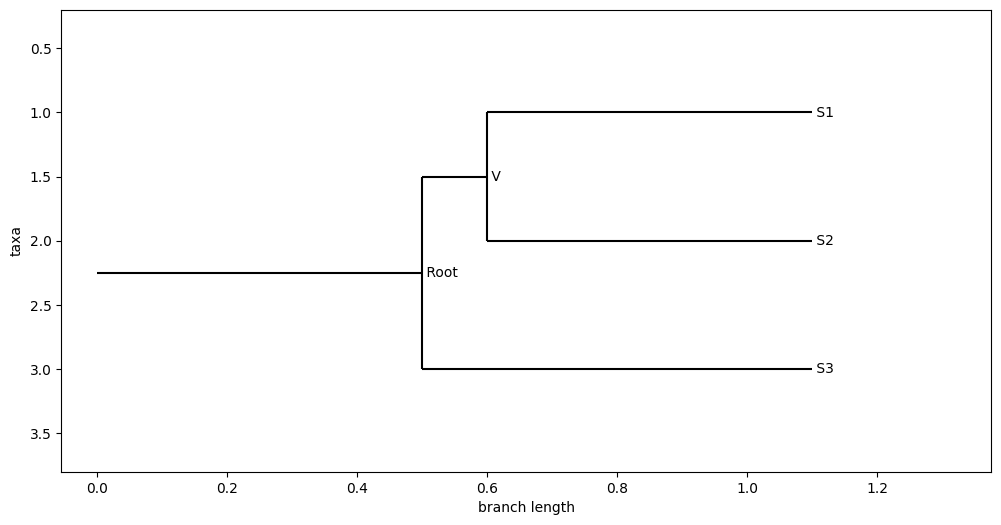

In [5]:
# Generate a tree from file.

seq_len = 5
alpha = 0.5

tree_file = Phylogenetic_Tree(seq_len, alpha).read_from_file("basic_tree.dnd")
tree_file.calculate_likelihood()
print(tree_file)
print(f"Likelihood: {tree_file.likelihood}")
tree_file.draw()

Phylogenetic_Tree(alpha=0.5, n_taxa=10, rooted=True, seq_len=6)
    Clade(branch_length=0.5, name='Root', sequence='TGTATC')
        Clade(branch_length=0.9, mutations=3, name='n0', sequence='TTTAAA')
            Clade(branch_length=0.9, mutations=3, name='n00', sequence='TTACAG')
                Clade(branch_length=0.5, mutations=2, name='n000', sequence='GTACAC')
                    Clade(mutations=2, name='S3', sequence='GTATGC')
                    Clade(branch_length=0.5, mutations=1, name='n0001', sequence='GTACTC')
                        Clade(mutations=3, name='S2', sequence='ATAAAC')
                        Clade(mutations=2, name='S4', sequence='AGACTC')
                Clade(branch_length=0.7, mutations=1, name='n001', sequence='TTACAC')
                    Clade(mutations=1, name='S5', sequence='TAACAC')
                    Clade(branch_length=0.1, mutations=0, name='n0011', sequence='TTACAC')
                        Clade(mutations=4, name='S6', sequence='CTAGCA')
       

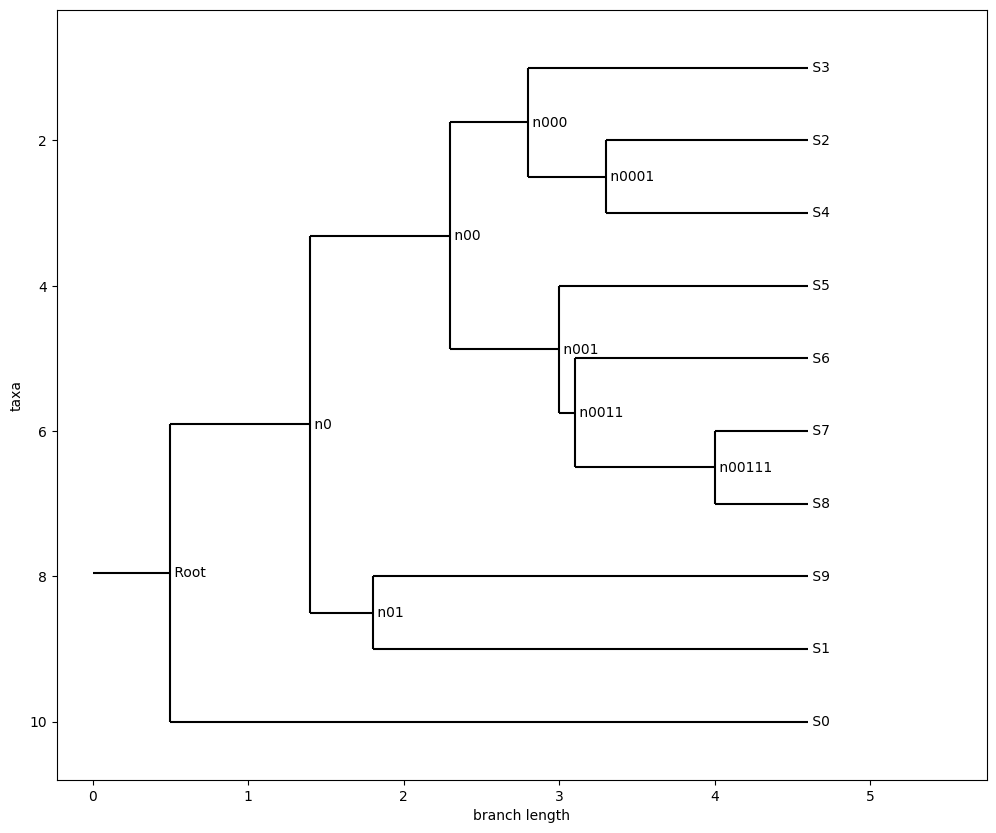

In [7]:
# Generate a random tree and write to file

seq_len = 6
alpha = 0.5
n_taxa = 10
# taxa_names = generate_random_taxa_names(n_taxa)

tree_random = Phylogenetic_Tree(seq_len, alpha).generate_random_tree(n_taxa=n_taxa, generate_sequences=True)
tree_random.calculate_likelihood()
print(tree_random)
print(f"Likelihood: {tree_random.likelihood}")
tree_random.draw(figsize=(12,10))
tree_random.write("random_tree.dnd")

### Explore tree space and evaluate posterior for tree

There is this class "classBio.Phylo.TreeConstruction.NNITreeSearcher(scorer)" but the only scorer it seems to accept is the ParsimonyScorer(). So probably will have to construct the NNI algorithm by hand.

In [ ]:
# # Changes to insert in commit:
# Construction of a Nearest-Neighbor interchange (NNI) searcher